In [1]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
from tqdm import tqdm

#use for naive_bayes
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,SnowballStemmer
from nltk.tokenize import TweetTokenizer
import pdb
from nltk.corpus import twitter_samples
import numpy as np
import pandas as pd
import nltk
from os import getcwd

from tensorflow.keras import layers
from tensorflow.keras import losses

nltk.download('stopwords')

#use for LSTM and WordEmbedding Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from  nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Prepare_Data

In [3]:
path = "/content/drive/MyDrive/Big_Data/custom_model/"
train_x = np.load(path + 'train_x.npz') 
train_y = np.load(path + 'train_y.npz')
test_x = np.load(path + 'test_x.npz')
test_y = np.load(path + 'test_y.npz')

In [4]:
train_x = np.array(train_x['arr_0'])
train_y = np.array(train_y['arr_0'])
test_x = np.array(test_x['arr_0'])
test_y = np.array(test_y['arr_0'])

In [5]:
%cd "/content/drive/MyDrive/Big_Data/custom_model"
 
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove/glove.6B.50d.txt')

/content/drive/.shortcut-targets-by-id/1BgtonPStw4rr3Qj0sGx2vyRPGSxU8TV5/Big_Data/custom_model


In [18]:
def sentence_to_avg(sentence,word_to_vec_map):
    any_word = list(word_to_vec_map.keys())[0]

    avg = np.zeros_like(word_to_vec_map[any_word[0]])


    w_list = sentence.strip().split()
    count = 0.0
    for w in w_list:
        if w in word_to_vec_map:
           avg += word_to_vec_map[w]
           count +=  1
    if count > 0:
      avg = avg / count
    
    return avg

def convert_doc2vec(x,word_to_vec_map):
    doc2vec = []

    #docs2vec
    for i in tqdm(range(len(x))):
        doc2vec.append(sentence_to_avg(x[i],word_to_vec_map))

    return doc2vec

train_dataset = convert_doc2vec(train_x,word_to_vec_map)

100%|██████████| 36000/36000 [05:54<00:00, 101.68it/s]


In [ ]:
train_x[0].split()

In [19]:
train_dataset_ = tf.convert_to_tensor(train_dataset)
train_y_ = tf.one_hot(train_y,2)

In [20]:
model_MLP = tf.keras.Sequential([
    tf.keras.layers.Dense(units=256,input_shape=(train_dataset_.shape[1],),activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units = 2, activation='softmax')
])

model_MLP.compile(
    loss='categorical_crossentropy',
    optimizer= tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [21]:
checkpoint_path = "/content/drive/MyDrive/Big_Data/custom_model/training_MLP/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq = 1013 * 2)

model_MLP.save_weights(checkpoint_path.format(epoch=0))

In [22]:
history = model_MLP.fit(
    train_dataset_, train_y_,
    epochs= 100,
    batch_size = 32,
    validation_split=0.1,
    verbose=1,
    shuffle=True,
    callbacks=[cp_callback]
)

Epoch 1/100
1013/1013 [==============================] - 5s 4ms/step - loss: 0.5766 - accuracy: 0.6981 - val_loss: 0.5306 - val_accuracy: 0.7383
Epoch 2/100
1005/1013 [============================>.] - ETA: 0s - loss: 0.5277 - accuracy: 0.7405
Epoch 2: saving model to /content/drive/MyDrive/Big_Data/custom_model/training_MLP/cp-0002.ckpt
1013/1013 [==============================] - 4s 4ms/step - loss: 0.5280 - accuracy: 0.7402 - val_loss: 0.5211 - val_accuracy: 0.7472
Epoch 3/100
1013/1013 [==============================] - 4s 4ms/step - loss: 0.5152 - accuracy: 0.7506 - val_loss: 0.5192 - val_accuracy: 0.7442
Epoch 4/100
1005/1013 [============================>.] - ETA: 0s - loss: 0.5135 - accuracy: 0.7520
Epoch 4: saving model to /content/drive/MyDrive/Big_Data/custom_model/training_MLP/cp-0004.ckpt
1013/1013 [==============================] - 4s 4ms/step - loss: 0.5133 - accuracy: 0.7519 - val_loss: 0.5166 - val_accuracy: 0.7458
Epoch 5/100
1013/1013 [==============================]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


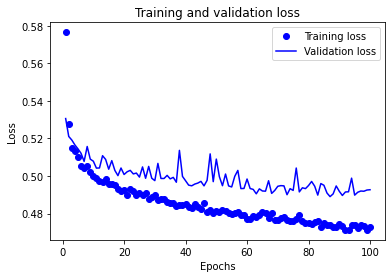

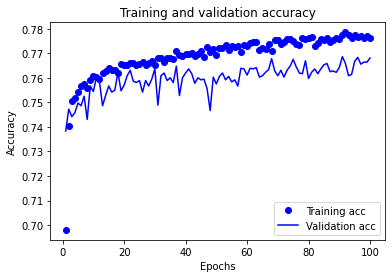

In [23]:
history_dict = history.history

print(history_dict.keys())

#visualization
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#Training and validation loss
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#training and validataion accuray
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [24]:
!cd "/content/drive/MyDrive/Big_Data/custom_model/" 
!mkdir -p saved_model

model_MLP.save('saved_model/my_model_MLP')

INFO:tensorflow:Assets written to: saved_model/my_model_MLP/assets


In [25]:
test_dataset = convert_doc2vec(test_x,word_to_vec_map)

100%|██████████| 9000/9000 [01:30<00:00, 99.01it/s] 


In [27]:
test_data = tf.convert_to_tensor(test_dataset)
test_y_ = tf.one_hot(test_y,2)

In [28]:
model_MLP.evaluate(test_data,test_y_)

282/282 [==============================] - 1s 5ms/step - loss: 0.4767 - accuracy: 0.7747


[0.4766924977302551, 0.7746666669845581]

In [43]:
def predict(sentence):
    x = [sentence]
    doc = []
    for i in range(len(x)):
        doc.append(sentence_to_avg(x[i],word_to_vec_map))
    doc = tf.convert_to_tensor(doc)
    res = model_MLP.predict(doc)[0]
    if res[0] > res[1]:
       return "negative"
    return "positive"

In [44]:
sentence = "hey you are terrible and i don't want you"
predict(sentence)

'negative'

In [45]:
sentence = "happy birthday, you are my everything"
predict(sentence)

'positive'